<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/5_30_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**

[규제 선형 모델의 개요]

좋은 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다. RSS를 최소화하는 것만 고려하다 보면 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커진다. 이렇게 변동성이 심해지면 테스트 데이터 세트에서는 예측 성능이 저하되기 쉽다. 이를 반영해 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 균형을 이뤄야 한다. 회귀 계수의 크기를 제어해 과적합을 개선하려면 비용함수의 목표가 RSS(W)+alpha*||W||(2,2)를 최소화하는 것으로 변경될 수 있다.

* alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터. 

  * alpha=0 : W가 커도 alpha*||W||(2,2)가 0이 되어 비용함수는 Min(RSS(W)). alpha 값을 작게 하면 회귀계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있다.

  * alpha=무한대 : alpha*||W||(2,2)도 무한대가 되므로 비용함수는 W를 0에 가깝게 최소화해야 함. alpha 값을 크게 하면 비용함수는 회귀계수 W의 값을 작게 해 과적합을 개선할 수 있다.

즉 alpha를 0부터 지속적으로 값을 증가시키면 회귀계수 값의 크기를 감소시킬 수 있다. 비용함수에 alpha 값으로 페널티를 부여해 회귀계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regulation)라고 한다.

* L2 규제 : alpha*||W||(2,2)와 같이 W의 제곱에 대해 페널티 부여. 릿지(Ridge) 회귀

* L1 규제 : alpha*||W||(1)와 같이 W의 절댓값에 대해 페널티 부여. 영향력이 크지 않은 회귀계수 값을 0으로 변환. 라쏘(Lasso) 회귀

[릿지 회귀]

사이킷런 Ridge 클래스로 구현. 주요 생성 파라미터 alpha는 릿지 회귀의 alpha L2 규제 계수.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

boston=load_boston()
bostonDF=pd.DataFrame(boston.data,columns=boston.feature_names)
bostonDF['PRICE']=boston.target

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)

#alpha=10으로 설정해 릿지 회귀 수행
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores: ',np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores: ',np.round(rmse_scores,3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

#결과 : 규제가 없는 LinearRegression의 RMSE 평균인 5.836보다 뛰어난 예측 성능 보임.

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
#alpha 값을 변화시키면서 RMSE 값과 각 피처의 회귀 계수를 시각화하고 DataFrame에 저장

#릿지에 사용될 alpha 파라미터 값 정의
alphas=[0,0.1,1,10,100]

#alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
  ridge=Ridge(alpha=alpha)

  #cross_val_score를 이용해 5 폴드의 평균 RMSE 계산
  neg_mse_scores=cross_val_score(ridge,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
  avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha,avg_rmse))

#결과 : alpha=100일 때 평균 RMSE가 가장 좋다.

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


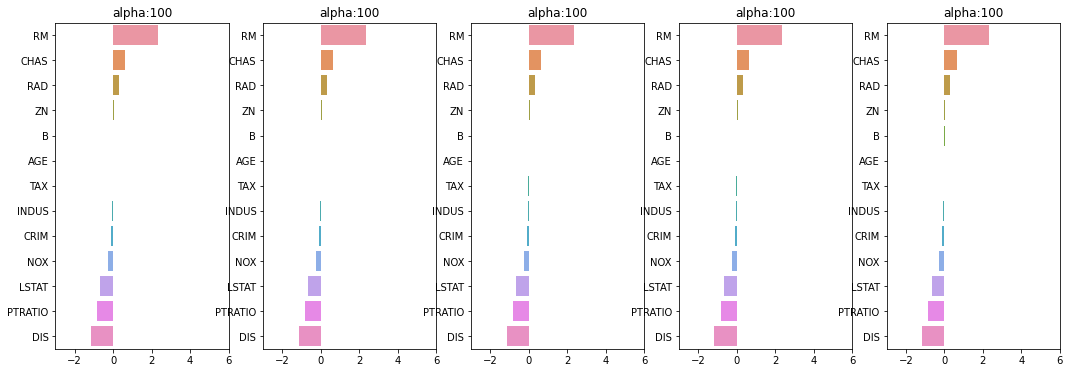

In [5]:
#각 alpha에 따른 회귀계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,axs=plt.subplots(figsize=(18,6),nrows=1,ncols=5)

#각 alpha에 따른 회귀계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df=pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alphs in enumerate(alphas):
  ridge=Ridge(alpha=alpha)
  ridge.fit(X_data,y_target)
  #alpha에 따른 피처별로 회귀계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
  coeff=pd.Series(data=ridge.coef_,index=X_data.columns)
  colname='alpha:'+str(alpha)
  coeff_df[colname]=coeff
  #막대 그래프로 각 alpha 값에서의 회귀계수를 시각화. 회귀계수 값이 높은 순으로 표현
  coeff=coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3,6)
  sns.barplot(x=coeff.values,y=coeff.index,ax=axs[pos])

#for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀계수를 DataFrame으로 표시
plt.show()

#결과 : alpha 값을 계속 증가시킬수록 회귀계수 값은 지속적으로 작아진다. 특히 NOX 피처에서 이 경향이 두드러진다.

In [4]:
#DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값

ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

KeyError: ignored

[라쏘 회귀]

사이킷런 Lasso 클래스로 구현. 주요 생성 파라미터 alpha는 라쏘 회귀의 alpha L1 규제 계수.

In [1]:
from sklearn.linear_model import Lasso, ElasticNet

#alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name,params=None,X_data_n=None,y_target_n=None,verbose=True):
  coeff_df=pd.DataFrame()
  if verbose : print('#######', model_name, '#######')
  for param in params:
    if model_name=='Ridge':model=Ridge(alpha=param)
    elif model_name=='Lasso':model=Lasso(alpha=param)
    elif model_name=='ElasticNet':model=ElasticNet(alpha=param,l1_ratio=0.7)
    neg_mse_scores=cross_val_score(model,X_data_n,y_target_n,scoring='neg_mean_squared_error',cv=5)
    avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param,avg_rmse))
    #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data,y_target)
    #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff=pd.Series(data=model.coef_,index=X_data.columns)
    colname='alpha:'+str(param)
    coeff_df[colname]=coeff
  return coeff_df
#end of get_linear_regre_eval

In [6]:
#라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df=get_linear_reg_eval('Lasso',params=lasso_alphas,X_data_n=X_data,y_target_n=y_target)

#결과 : alpha=0.07일 때 가장 좋은 평균 RMSE

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [8]:
#반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀게수 DataFrame 출력
sort_column='alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column,ascending=False)

#결과 : alpha의 크기가 증가함에 따라 일부 피처의 회귀계수는 0으로 바뀜

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


[엘라스틱넷 회귀]

L2 규제와 L1 규제를 결합한 회귀. RSS(W)+alpha2 * ||W||(2,2)+alpha1*||W||(1)을 최소화하는 W 찾기. 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하다.

사이킷런 ElasticNet 클래스로 구현. 주요 생성 파라미터는 alpha, l1_ratio. 엘라스틱넷의 규제는 a * L1+b*L2로 정의되는데 이때 a가 L1 규제의 alpha값, b는 L2 규제의 alpha값이다. 따라서 ElasticNet 클래스의 alpha값은 a+b이다. l1_ratio 파라미터 값은 a/(a+b)이다. l1_ratio가 0이면 a가 0이므로 L2 규제와 동일. l1_ration가 1이면 b가 0이므로 L1 규제와 동일.

In [7]:
#엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
#l1_ratio는 0.7로 고정
elastic_alphas=[0.07,0.1,0.5,1,3]
coeff_elastic_df=get_linear_reg_eval('ElasticNet',params=elastic_alphas,X_data_n=X_data,y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [8]:
#반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column='alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column,ascending=False)

#결과 : alpha=0.5일 때 RMSE가 가장 좋은 예측 성능을 보인다. 라쏘 회귀보다 alpha값에 따른 피처들의 회귀계수들 값이 0이 되는 값이 적다.

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


[선형 회귀 모델을 위한 데이터 변환]

선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고 최적의 선형함수를 찾아내 결과값을 예측한다. 또한 피처값과 타깃값의 분포가 정규분포인 형태를 매우 선호한다. 특히 타깃값은 skewed 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 수 있다. 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행해야 한다.

1. StandardScaler 클래스를 이용해 평균 0, 분산 1인 표준정규분포를 가진 데이터세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0, 최댓값이 1인 값으로 정규화 수행

2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환

3. 로그 변환

타깃값은 일반적으로 로그 변환을 적용한다.

In [9]:
#method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
#p_degree는 다항식 특성을 추가할 때 적용. 2 이상 부여하지 않음

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None',p_degree=None,input_data=None):
  if method=='Standard':
    scaled_data=StandardScaler().fit_transform(input_data)
  elif method=='MinMAx':
    scaled_data=MinMaxScaler().fit_transform(input_data)
  elif method=='Log':
    scaled_data=np.log1p(input_data)
  else:
    scaled_data=input_data
  
  if p_degree!=None:
    scaled_data=PolynomialFeatures(degree=p_degree,include_bias=False).fit_transform(scaled_data)
  
  return scaled_data

In [12]:
#Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas=[0.1,1,10,100]

#5개 방식으로 변환. 먼저 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
#최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None,None),('Standard',None),('Standard',2),('MinMax',None),('MinMax',2),('Log',None)]
for scale_method in scale_methods:
  X_data_scaled=get_scaled_data(method=scale_method[0],p_degree=scale_method[1],input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
  get_linear_reg_eval('Ridge',params=alphas,X_data_n=X_data_scaled,y_target_n=y_target,verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 9.141
alpha 1일 때 5 폴드 세트의 평균 RMSE: 8.938
alpha 10일 때 5 폴드 세트의 평균 RMSE: 10.556
alpha 100일 때 5 폴드 세트의 평균 RMSE: 10.566

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.7

**07. 로지스틱 회귀**

선형 회귀 방식을 분류에 적용한 알고리즘. 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류 결정.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer=load_breast_cancer()

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균 0, 분산 1인 데이터 분포도 변환
scaler=StandardScaler()
data_scaled=scaler.fit_transform(cancer.data)

X_train,X_test,y_train,y_test=train_test_split(data_scaled,cancer.target,test_size=0.3,random_state=0)

In [15]:
from sklearn.metrics import accuracy_score,roc_auc_score

#로지스틱 회귀를 이용해 학습 및 예측 수행
lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_preds=lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test,lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test,lr_preds)))

accuracy: 0.977
roc_auc: 0.972


In [18]:
from sklearn.model_selection import GridSearchCV

params={ 'penalty': ['l2','l1'],'C':[0.01,0.1,1,1,5,10]}

grid_clf=GridSearchCV(lr_clf,param_grid=params,scoring='accuracy',cv=3)
grid_clf.fit(data_scaled,cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

**08. 회귀 트리**

트리 기반의 회귀는 회귀 트리를 이용하는 것이다. 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것이다. 회귀 트리는 분류 트리와 크게 다르지 않으나 리프 노드에서 예측 결정값을 만드는 과정에 차이가 있다. 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다.

사이킷런에서는 결정 트리, 랜덤포레스트, GBM에서 CART 기반의 회귀 수행을 할 수 있는 Estimator 클래스를 제공한다. XGBoost, LightGBM도 사이킷런 래퍼 클래스를 통해 이를 제공한다.

In [19]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

#보스턴 데이터 세트 로드
boston=load_boston()
bostonDF=pd.DataFrame(boston.data,columns=boston.feature_names)

bostonDF['PRICE']=boston.target
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)

rf=RandomForestRegressor(random_state=0,n_estimators=1000)
neg_mse_scores=cross_val_score(rf,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 교차 검증의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [20]:
def get_model_cv_prediction(model,X_data,y_target):
  neg_mse_scores=cross_val_score(model,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
  rmse_scores=np.sqrt(-1*neg_mse_scores)
  avg_rmse=np.mean(rmse_scores)
  print('#####',model.__class__.__name__,'#####')
  print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg=DecisionTreeRegressor(random_state=0,max_depth=4)
rf_reg=RandomForestRegressor(random_state=0,n_estimators=1000)
gb_reg=GradientBoostingRegressor(random_state=0,n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgb_reg=LGBMRegressor(n_estimators=1000)

#트리 기반의 회귀 모델을 반복하면서 평가 수행
models=[dt_reg,rf_reg,gb_reg,xgb_reg,lgb_reg]
for model in models:
  get_model_cv_prediction(model,X_data,y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE:5.978
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE:4.423
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE:4.269
[07:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
##### XGBRegressor #####
5 교차 검증의 평균 RMSE:4.089
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE:4.646


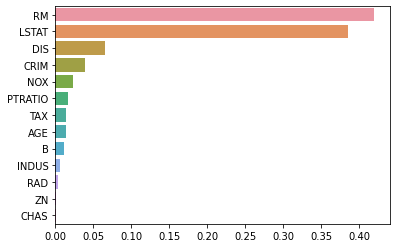

In [26]:
import seaborn as sns
%matplotlib inline

rf_reg=RandomForestRegressor(n_estimators=1000)

#앞 예제에서 만들어진 X_data, y_target 데이터 세트 적용해 학습
rf_reg.fit(X_data,y_target)

feature_series=pd.Series(data=rf_reg.feature_importances_,index=X_data.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)

(100, 2)


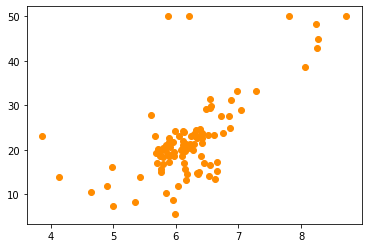

In [27]:
bostonDF_sample=bostonDF[['RM','PRICE']]
bostonDF_sample=bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM,bostonDF_sample.PRICE,c='darkorange')

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression

#선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7
lr_reg=LinearRegression()
rf_reg2=DecisionTreeRegressor(max_depth=2)
rf_reg7=DecisionTreeRegressor(max_depth=7)

#실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성
X_test=np.arange(4.5,8.5,0.04).reshape(-1,1)

#보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature=bostonDF_sample['RM'].values.reshape(-1,1)
y_target=bostonDF_sample['PRICE'].values.reshape(-1,1)

#학습과 예측 수행
lr_reg.fit(X_feature,y_target)
rf_reg2.fit(X_feature,y_target)
rf_reg7.fit(X_feature,y_target)

pred_lr=lr_reg.predict(X_test)
pred_rf2=rf_reg2.predict(X_test)
pred_rf7=rf_reg7.predict(X_test)

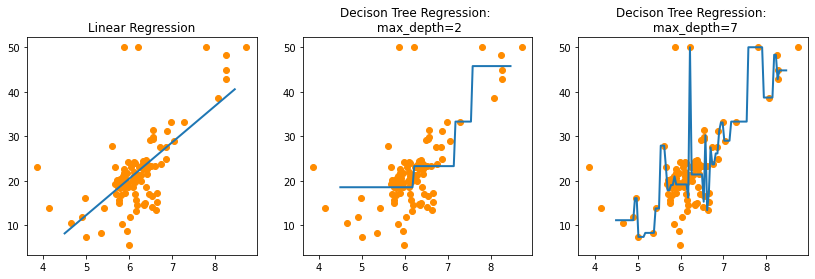

In [29]:
fig,(ax1,ax2,ax3)=plt.subplots(figsize=(14,4),ncols=3)

#X축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화

#선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM,bostonDF_sample.PRICE,c='darkorange')
ax1.plot(X_test,pred_lr,label='linear',linewidth=2)

#DecisoinTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decison Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM,bostonDF_sample.PRICE,c='darkorange')
ax2.plot(X_test,pred_rf2,label='max_dept:3',linewidth=2)

#DecisoinTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decison Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM,bostonDF_sample.PRICE,c='darkorange')
ax3.plot(X_test,pred_rf7,label='max_dept:7',linewidth=2)